In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_50Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_66Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_75Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_AllAgree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/License.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/README.txt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import missingno as miss
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
from tqdm import tqdm

from nltk.corpus import stopwords    
from nltk.tokenize import word_tokenize
from textblob import TextBlob

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, MaxPooling1D, Conv1D, Concatenate, Bidirectional, GlobalMaxPool1D, ActivityRegularization, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix

In [3]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv", encoding='latin-1', header = None)
df.columns = ["Sentiment", "News Headline"]
df.head()

,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
df.shape

(4846, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      4846 non-null   object
 1   News Headline  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [6]:
df.describe(include = "all")

,Sentiment,News Headline
count,4846,4846
unique,3,4838
top,neutral,The report profiles 614 companies including ma...
freq,2879,2


In [7]:
df.isna().sum()

Sentiment        0
News Headline    0
dtype: int64

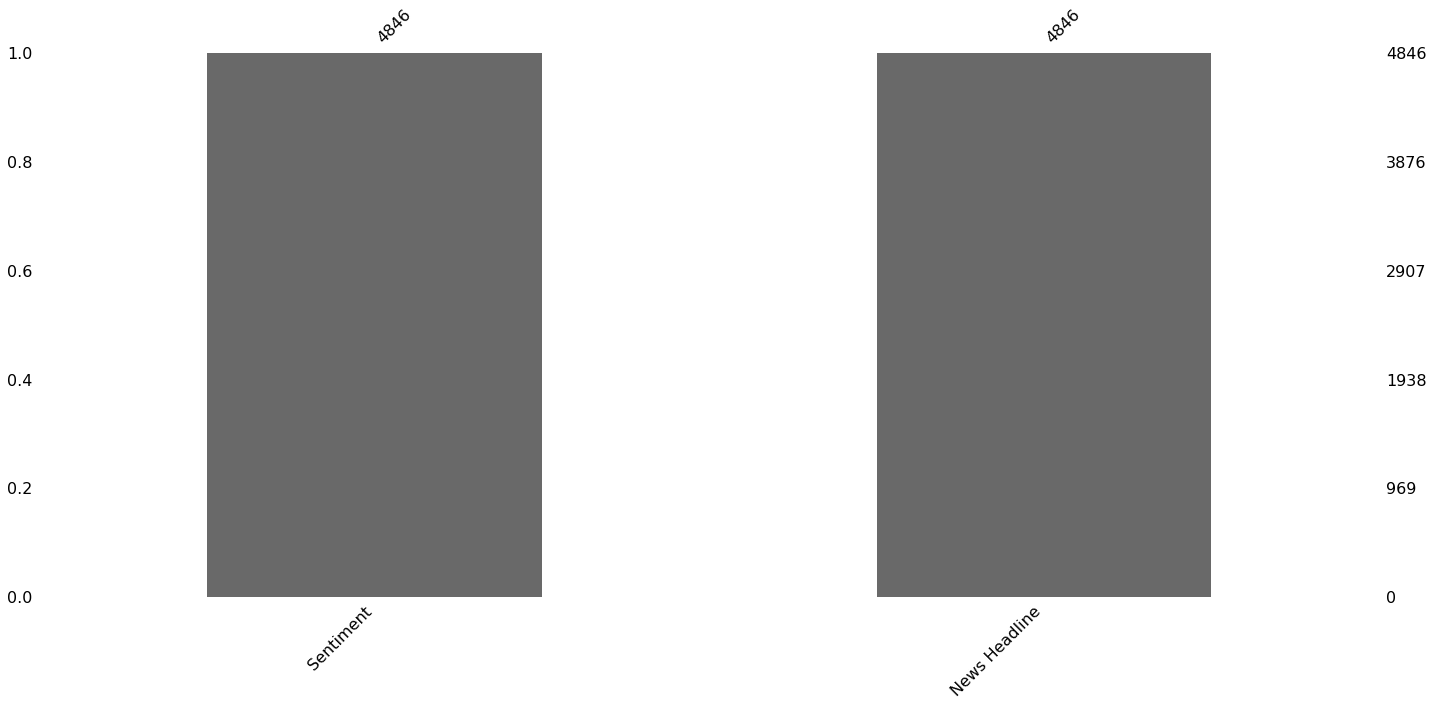

In [8]:
miss.bar(df)
plt.show()

In [9]:
#check for duplicates

len(df[df.duplicated()])

6

In [10]:
df = df.drop_duplicates()
print(df.head())
print(df.shape)

  Sentiment                                      News Headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
(4840, 2)


## Number of Characters

In [11]:
df['nr_of_char'] = df['News Headline'].str.len()
df['nr_of_char'] = df['nr_of_char'] / df['nr_of_char'].max()
df[['Sentiment', 'nr_of_char']].pivot(columns = 'Sentiment', values = 'nr_of_char').iplot(kind = 'box')

## Number of words

In [12]:
df['nr_of_words'] = df['News Headline'].str.split().str.len()
df['nr_of_words'] = df['nr_of_words'] / df['nr_of_char'].max()
df[['Sentiment', 'nr_of_words']].pivot(columns = 'Sentiment', values = 'nr_of_words').iplot(kind = 'box')

## Number of unique words

In [13]:
df['nr_of_unique_words'] = df['News Headline'].apply(lambda x: len(set(x.split())))
df['nr_of_unique_words'] = df['nr_of_unique_words'] / df['nr_of_unique_words'].max()
df[['Sentiment', 'nr_of_unique_words']].pivot(columns = 'Sentiment', values = 'nr_of_unique_words').iplot(kind='box')

## Number of punctuation marks

In [14]:
df['nr_of_punctuation'] = df['News Headline'].str.split(r"\?|,|\.|\!|\"|'").str.len()
df['nr_of_punctuation'] = df['nr_of_punctuation'] / df['nr_of_punctuation'].max()
df[['Sentiment', 'nr_of_punctuation']].pivot(columns = 'Sentiment', values = 'nr_of_punctuation').iplot(kind = 'box')

## Number of stopwords

In [15]:
stop_words = set(stopwords.words('english'))
df['nr_of_stopwords'] = df['News Headline'].str.split().apply(lambda x: len(set(x) & stop_words))
df['nr_of_stopwords'] = df['nr_of_stopwords'] / df['nr_of_stopwords'].max()
df[['Sentiment', 'nr_of_stopwords']].pivot(columns = 'Sentiment', values = 'nr_of_stopwords').iplot(kind = 'box')

## Feature correlation matrix

In [16]:
df.corr().iplot(kind='heatmap',colorscale="YlGnBu",title="Feature Correlation Matrix")

## Target Distribution

In [17]:
df.insert(0, 'Id', range(1, 1 + len(df))) #defining custom Id column
def show_donut_plot(col): #donut plot function
    
    rating_data = df.groupby(col)[['Id']].count().head(10)
    plt.figure(figsize = (12, 8))
    plt.pie(rating_data[['Id']], autopct = '%1.0f%%', startangle = 140, pctdistance = 1.1, shadow = True)

    # create a center circle for more aesthetics to make it better
    gap = plt.Circle((0, 0), 0.5, fc = 'white')
    fig = plt.gcf()
    fig.gca().add_artist(gap)
    
    plt.axis('equal')
    
    cols = []
    for index, row in rating_data.iterrows():
        cols.append(index)
    plt.legend(cols)
    
    plt.title('Donut Plot: Reviews \n', loc='center')
    plt.show()

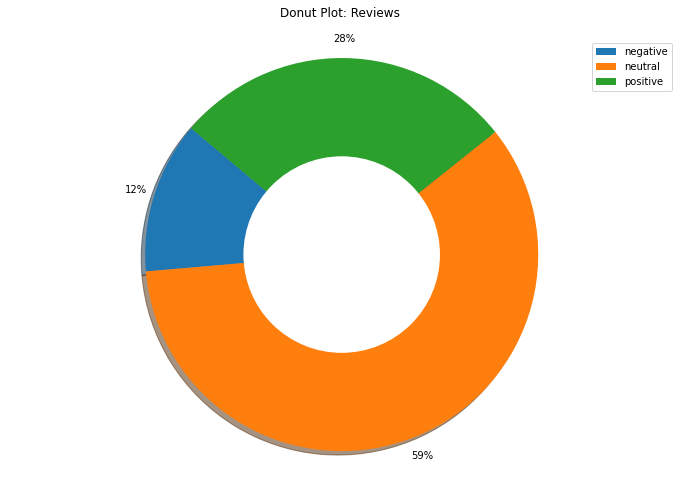

In [18]:
show_donut_plot('Sentiment')

## Cleaning the text column

In [19]:
import re
import spacy
nlp = spacy.load('en')

def normalize(msg):
    
    msg = re.sub('[^A-Za-z]+', ' ', msg) #remove special character and intergers
    doc = nlp(msg)
    res=[]
    for token in doc:
        if(token.is_stop or token.is_punct or token.is_currency or token.is_space or len(token.text) <= 2): #word filteration
            pass
        else:
            res.append(token.lemma_.lower())
    return res

In [20]:
df["News Headline"] = df["News Headline"].apply(normalize)

In [21]:
df.head()

,Id,Sentiment,News Headline,nr_of_char,nr_of_words,nr_of_unique_words,nr_of_punctuation,nr_of_stopwords
0,1,neutral,"[accord, gran, company, plan, production, russ...",0.403175,25.0,0.413043,0.111111,0.444444
1,2,neutral,"[technopolis, plan, develop, stage, area, squa...",0.603175,31.0,0.608696,0.111111,0.444444
2,3,negative,"[international, electronic, industry, company,...",0.723810,36.0,0.673913,0.083333,0.388889
3,4,positive,"[new, production, plant, company, increase, ca...",0.653968,33.0,0.521739,0.055556,0.333333
4,5,positive,"[accord, company, update, strategy, year, basw...",0.644444,41.0,0.695652,0.111111,0.444444


In [22]:
words_collection = Counter([item for sublist in df['News Headline'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(20))
freq_word_df.columns = ['frequently_used_word','count']

In [23]:
fig = px.scatter(freq_word_df, x="frequently_used_word", y="count", color="count", title = 'Frequently used words - Scatter plot')
fig.show()

In [24]:
df["News Headline"] = df["News Headline"].apply(lambda x : " ".join(x))
df = df[["News Headline", "Sentiment"]]
df["Sentiment"] = le.fit_transform(df["Sentiment"])
df.head()

,News Headline,Sentiment
0,accord gran company plan production russia com...,1
1,technopolis plan develop stage area square met...,1
2,international electronic industry company elco...,0
3,new production plant company increase capacity...,2
4,accord company update strategy year basware ta...,2


## Let's start with BERT

In [25]:
rename = {"News Headline": "text", "Sentiment": "labels"}
df.rename(columns = rename, inplace=True)

In [26]:
!pip install transformers
!pip install simpletransformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 209 kB 574 kB/s eta 0:00:01
     |████████████████████████████████| 884 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 4.4 MB 8.8 MB/s eta 0:00:01


     |████████████████████████████████| 120 kB 19.3 MB/s eta 0:00:01


  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=e1ae51ebb13903a0d773e7aaae3db618183461d1ffdafb774ff0adf4f7e67c01
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.45.0
    Uninstalling tqdm-4.45.0:
      Successfully uninstalled tqdm-4.45.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.1.1
    Uninstalling ipykernel-5.1.1:
      Successfully uninstalled ipykernel-5.1.1
  Attempting uninstall: cachetools
    Found existing installation: cachetools 3.1.1
    Uninstalling cachetools-3.1.1:
      Successfully uninstalled cachetools-3.1.1
ERROR: After October 2020 you may experience errors when

In [27]:
train_x_y = df.sample(frac = 0.75, random_state = 42)
test_x_y = pd.concat([df, train_x_y]).drop_duplicates(keep=False)

In [28]:
print(train_x_y.shape)
print(test_x_y.shape)

(3630, 2)
(1170, 2)


In [29]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs


model_args = ClassificationArgs()
model_args.train_batch_size = 2
model_args.gradient_accumulation_steps = 8
model_args.learning_rate = 3e-5
model_args.num_train_epochs = 1

model_bert = ClassificationModel("bert", "bert-base-uncased", num_labels=3, args=model_args, use_cuda=False)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [30]:
model_bert.train_model(train_x_y)

In [31]:
pred_bert, out_bert = model_bert.predict(test_x_y['text'].values)

acc_bert = accuracy_score(test_x_y['labels'].to_numpy(), pred_bert)
f1_bert = f1_score(test_x_y['labels'].to_numpy(), pred_bert, average='micro')

print("Accuracy score -->", acc_bert)
print("F1 score -->", f1_bert)


Accuracy score --> 0.7666666666666667
F1 score --> 0.7666666666666667


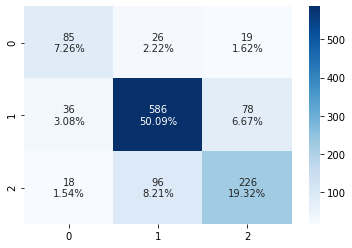

In [40]:
#graph with confusion matrix

cm = confusion_matrix(pred_bert, test_x_y['labels'].to_numpy())
#group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

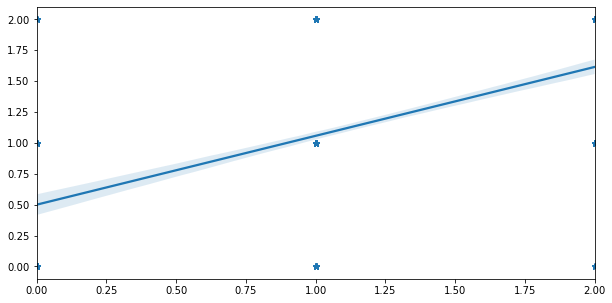

In [33]:
fig,ax=plt.subplots(figsize=(10,5))
sns.regplot(x=pred_bert, y=test_x_y['labels'].to_numpy(),marker="*")
plt.show()